In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import os
import glob
from brainspace.gradient import GradientMaps
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69


In [3]:
# 1. specify the subjects and directories
subs = ['HC048', 'HC043', 'HC087', 'HC037', 'HC055', 'HC100', 'HC036', 'HC017', 'HC088', 'HC040', 'HC058', 'HC076', 'HC090', 'HC059', 'HC101', 'HC063', 'HC094', 'HC024', 'HC050',
 'HC080', 'HC013', 'HC026', 'HC001', 'HC084', 'HC105', 'HC083', 'HC042', 'HC014', 'HC033', 'HC081', 'HC106', 'HC108', 'HC095', 'HC002', 'HC102', 'HC028', 'HC020', 'HC049',
 'HC007', 'HC023', 'HC065', 'HC025', 'HC056', 'HC003', 'HC015', 'HC077', 'HC067', 'HC072', 'HC109', 'HC086', 'HC089', 'HC091', 'HC031', 'HC039', 'HC112', 'HC068', 'HC034',
 'HC032', 'HC060', 'HC047', 'HC103', 'HC046', 'HC009', 'HC097', 'HC116', 'HC053', 'HC079', 'HC029', 'HC075', 'HC078', 'HC057', 'HC018', 'HC074', 'HC064',
 'HC096', 'HC010', 'HC038', 'HC093', 'HC082', 'HC092', 'HC027', 'HC019', 'HC005', 'HC008', 'HC011', 'HC044', 'HC030', 'HC035', 'HC085', 'HC069', 'HC041', 'HC012', 'HC054', 'HC022', 'HC016', 'HC099',
 'HC073', 'HC052', 'HC045']
ses = '01'
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0' #NOTE rsfMRI data seems to be missing!
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'
tmp_dir = 'tmp_MICs-FC'
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'

tmp_dir = 'tmp_func'

# 2. Prepare data and analysis parameters 
hemis = ['L','R']
labels = ['hipp']# ,'dentate'] 
sigma = 1 #Gaussian smoothing kernal sigma (mm)
ind = [range(419)]#, range(419,483)]
shp = [419]#,64]

# 3. Load neocortical surfaces for visualzation 
parcL = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_lh.label.gii').darrays[0].data
parcR = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_rh.label.gii').darrays[0].data
parc = np.concatenate((parcL,parcR))
c69_inf_lh= read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_inf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')
labeling = load_parcellation('schaefer', scale=400, join=True)
atlas = 'schaefer-400'
# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)
# Mask of the medial wall
mask_c69 = labels_c69 != 0

# 0. Map rsfMRI data to hippocampal surfaces

In [ ]:
%%capture
!mkdir -p {tmp_dir}

for sub in subs:
    if not glob.glob(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemis[-1]}_space-T1w_den-2mm_label-{labels[-1]}_rsfMRI_smooth-{sigma}mm.func.gii'):
        # convert affines
        cmd1a = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-se_task-rest_acq-AP_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
        !{cmd1a}
        cmd1b = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat '\
            f'-inv '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
        !{cmd1b}

        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                #apply affines
                cmd2a = f'wb_command -surface-apply-affine '\
                    f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

                !{cmd2a}
                cmd2b = f'wb_command -surface-apply-affine '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                !{cmd2b}

                # apply warp (Note this is actually the INVERSE warp)
                cmd3 = f'wb_command -surface-apply-warpfield '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                !{cmd3}


                # sample
                cmd4 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-rest_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                    f'-enclosing'
                !{cmd4}

                # smooth
                cmd5 = f'wb_command -metric-smoothing '\
                    f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                    f'{sigma} '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii '
                !{cmd5}

                # downsample
                func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii')
                out_array = np.ones((len(func.darrays),shp[l]))
                for k in range(len(func.darrays)):
                    data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                    out_array[k,:] = data
                data_array = nib.gifti.GiftiDataArray(data=out_array)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_rsfMRI_smooth-{sigma}mm.func.gii')
!rm -r {tmp_dir}

In [3]:
cdata_hipp = np.ones((np.sum(shp),2,695,len(subs)))*np.nan
for s,sub in enumerate(subs):
    try:
        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                cdata_hipp[ind[l],h,:,s] = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_rsfMRI_smooth-{sigma}mm.func.gii').darrays[0].data.T[:,:695]
    except:
        print(sub)

# 1. Intrinsic Timescale of hippocampal rsfMRI

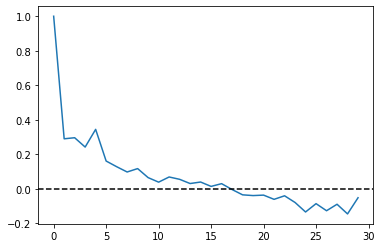

In [4]:
# sample a random vertex
t = cdata_hipp[5,0,:,0]
m = np.mean(t)
var = np.var(t)
ndat = t - m
acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
acf = acf / var / len(ndat)
plt.plot(acf[:30])
plt.axhline(y = 0, color = 'k', linestyle = '--') 

In [5]:
def IntrinsicTimescale(data, TR=1, threshold=0):
    '''computes instrinsic timescale - the AUC of the autocorrelation up to the point 
    where the autocorrelation reaches threshold. 
    Input
      img: input ND data, time being the last dimension
    '''
    shp = data.shape
    i = data.reshape(-1, shp[-1])
    out = np.zeros(i.shape[0])
    for v in range(i.shape[0]):
        m = np.mean(i[v,:])
        var = np.var(i[v,:])
        ndat = i[v,:] - m
        acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
        acf = acf / var / len(ndat)
        f = np.where(acf<=threshold)[0]
        if len(f)==0:
            out[v] = np.nan
        else:
            out[v] = f[0]
    out = np.reshape(out,shp[:-1])*TR
    return out

In [6]:
sub = subs[0]
TR = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-rest_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz').header.get_zooms()[-1]
IntTS = np.ones((np.sum(shp),2,len(subs)))*np.nan
for s,sub in enumerate(subs):
    IntTS[:,:,s] = IntrinsicTimescale(cdata_hipp[:,:,:,s],TR, threshold=0)

/data/mica1/01_programs/tmp/ipykernel_46909/2710468927.py:15: RuntimeWarning: invalid value encountered in true_divide
  acf = acf / var / len(ndat)


/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


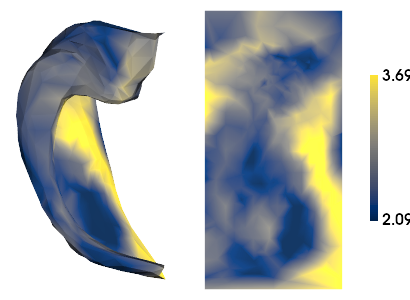

In [7]:
plotting.surfplot_canonical_foldunfold(np.nanmean(IntTS,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

(0.0, 15.0)

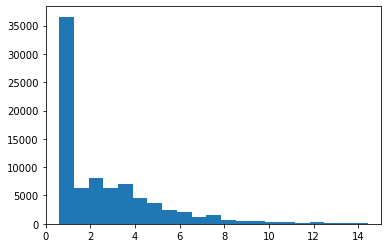

In [8]:
plt.hist(IntTS.flatten(),bins=50);
plt.xlim([0,15])

In [9]:
# save a copy of the 2D map
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):    
        cdat = np.nanmean(IntTS,axis=2)[ind[l],h]
        data_array = nib.gifti.GiftiDataArray(data=cdat)
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-IntTS_average-{len(subs)}_hemi-{hemi}_den-2mm_label-{label}.shape.gii')

# 2. Calcualte ReHo

In [10]:
def kendall_w(expt_ratings):
    if expt_ratings.ndim!=2:
        raise 'ratings matrix must be 2-dimensional'
    m = expt_ratings.shape[0] #raters
    n = expt_ratings.shape[1] # items rated
    denom = m**2*(n**3-n)
    rating_sums = np.sum(expt_ratings, axis=0)
    S = n*np.var(rating_sums)
    return 12*S/denom
def calc_reho(ts,F):
    # note ts should be shape VxT
    reho = np.ones((ts.shape[0]))*np.nan
    for v in range(ts.shape[0]):
        frows = np.unique(np.where(np.isin(F,v))[0])
        verts = np.unique(F[frows,:])
        reho[v] = kendall_w(ts[verts,:])
    return reho

/data/mica1/01_programs/tmp/ipykernel_46909/1598160367.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pc = art3d.Poly3DCollection(v[f], faceColor=[0, 0, 0, 0], edgeColor=[0,0,0,1])


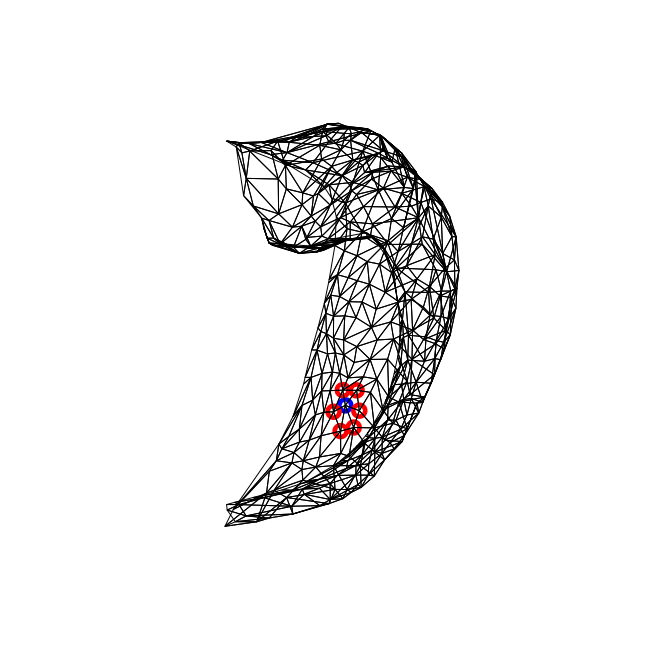

In [37]:
from mpl_toolkits.mplot3d import art3d
resourcesdir = '/export03/data/opt/hippunfold_toolbox/resources'

def plotwire(ax,f,v):
    pc = art3d.Poly3DCollection(v[f], faceColor=[0, 0, 0, 0], edgeColor=[0,0,0,1])
    ax.add_collection(pc)
    ax.set_xlim([np.min(v[:,0]),np.max(v[:,0])])
    ax.set_ylim([np.min(v[:,1]),np.max(v[:,1])])
    ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])
    ax.view_init(elev=90, azim=-90)
    ax = set_axes_equal(ax)
    ax.axis('off')
    return ax
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale.  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.
    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().'''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    return ax

den='2mm'
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12), subplot_kw={'projection': "3d"})
plotwire(ax,f,v)
i = 199
frows = np.unique(np.where(np.isin(f,i))[0])
verts = np.unique(F[frows,:])
verts = np.delete(verts,verts==i)
ax.scatter(v[verts,0],v[verts,1],v[verts,2],marker='o',color='none', alpha=1, edgecolor='r', linewidth =12)
ax.scatter(v[i,0],v[i,1],v[i,2],marker='o',color='none', alpha=1, edgecolor='b', linewidth =12)

In [12]:
reho = np.ones((np.sum(shp),2,len(subs)))*np.nan
for s,sub in enumerate(subs):
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            Fname = f'/host/cassio/export03/data/opt/hippunfold_toolbox/resources/canonical_surfs/tpl-avg_space-unfold_den-2mm_label-{label}_midthickness.surf.gii'
            F = nib.load(Fname).get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
            reho[ind[l],h,s] = calc_reho(cdata_hipp[ind[l],h,:,s],F)

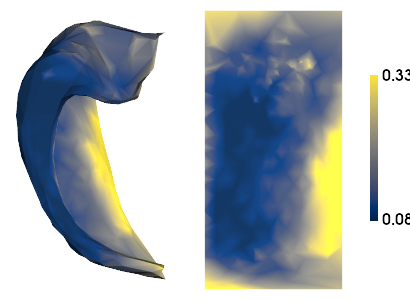

In [13]:
plotting.surfplot_canonical_foldunfold(np.nanmean(reho,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

In [ ]:
# save a copy of the 2D map
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):    
        cdat = np.nanmean(reho,axis=2)[ind[l],h]
        data_array = nib.gifti.GiftiDataArray(data=cdat)
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-ReHo_average-99_hemi-{hemi}_den-2mm_label-{label}.shape.gii')

## tSNR (TODO: get mid-processed version)

/data/mica1/01_programs/tmp/ipykernel_46909/1848611998.py:1: RuntimeWarning: invalid value encountered in true_divide
  tSNR = np.mean(cdata_hipp,axis=2) / np.std(cdata_hipp,axis=2)


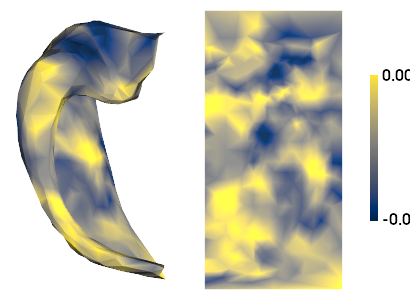

In [14]:
tSNR = np.mean(cdata_hipp,axis=2) / np.std(cdata_hipp,axis=2)
plotting.surfplot_canonical_foldunfold(np.nanmean(tSNR,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

# 3. Functional connectivity of the hippocampus to neocortex

In [15]:
#run gradients for all subjects
FC = np.ones((np.sum(shp),200,2,len(subs)))*np.nan

missingsubs = []
for s,sub in enumerate(subs):
    try:
        neo_ts = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-rest_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
        neo_ts_parc = np.ones((neo_ts.shape[0],400))
        for i in range(400):
             neo_ts_parc[:,i] = np.nanmean(neo_ts[:,parc==(i+1)],axis=1)
        neo_tsL = neo_ts_parc[:,:200]   
        neo_tsR = neo_ts_parc[:,200:]
        for h,hemi in enumerate(hemis):
            if hemi == 'L':
                FC[:,:,h,s] = np.corrcoef(cdata_hipp[:,h,:,s],neo_tsL.T)[:np.sum(shp),np.sum(shp):]
            else:            
                FC[:,:,h,s] = np.corrcoef(cdata_hipp[:,h,:,s],neo_tsR.T)[:np.sum(shp),np.sum(shp):]
    except:
        missingsubs.append(sub)
len(missingsubs)

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


19

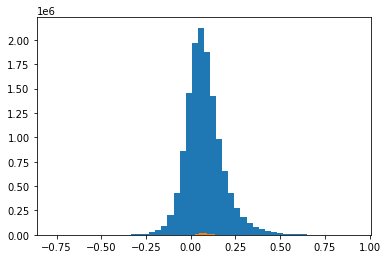

In [16]:
plt.hist(FC.flatten(),bins=50);
plt.hist(np.nanmean(FC,axis=(3)).flatten(),bins=50);

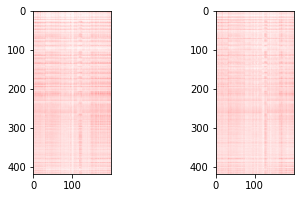

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(3*2,3))

ax[0].imshow(np.nanmean(FC[:,:,0,:],axis=(2)), vmin=-.5, vmax=.5, cmap='bwr')
ax[1].imshow(np.nanmean(FC[:,:,1,:],axis=(2)), vmin=-.5, vmax=.5, cmap='bwr')

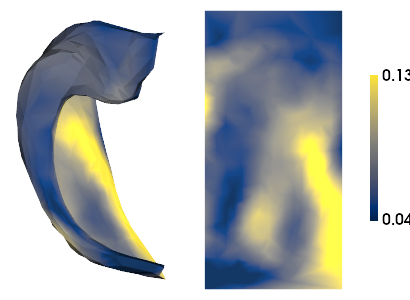

In [18]:
plotting.surfplot_canonical_foldunfold(np.nanmean(FC,axis=(1,2,3)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

In [19]:
# save a copy of the 2D map
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):    
        cdat = np.nanmean(FC,axis=(1,3))[ind[l],h]
        data_array = nib.gifti.GiftiDataArray(data=cdat)
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-avgFCneocort_average-{len(subs)-len(missingsubs)}_hemi-{hemi}_den-2mm_label-{label}.shape.gii')

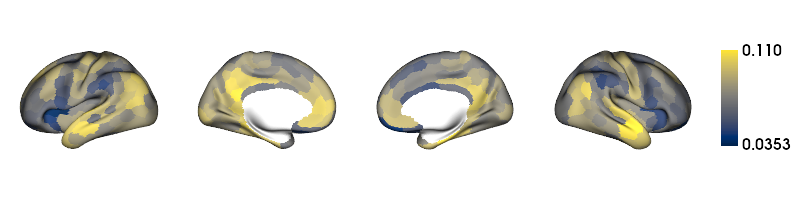

In [21]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(200):
        mc[parc==(i+1+(h*200))] = np.nanmean(FC[:,i,h,:],axis=(0,1))
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,1), 
                 size=(800,200), color_bar=True, cmap='cividis', embed_nb=True,nan_color=(1, 1, 1, 1))

# check consistency

In [22]:
feats = ["IntTS", "ReHo", "FC"]
mfcorr = []
sdfcorr = []

corr = np.corrcoef(IntTS.reshape((np.sum(shp),-1)).T)
fcorr = corr[np.triu_indices(len(subs)*2,k=1)]
mfcorr.append(np.nanmean(fcorr))
sdfcorr.append(np.nanstd(fcorr))

corr = np.corrcoef(reho.reshape((np.sum(shp),-1)).T)
fcorr = corr[np.triu_indices(len(subs)*2,k=1)]
mfcorr.append(np.nanmean(fcorr))
sdfcorr.append(np.nanstd(fcorr))

corr = np.corrcoef(FC.reshape((np.sum(shp),-1)).T)
fcorr = corr[np.triu_indices(len(subs)*2*200,k=1)]
mfcorr.append(np.nanmean(fcorr))
sdfcorr.append(np.nanstd(fcorr))

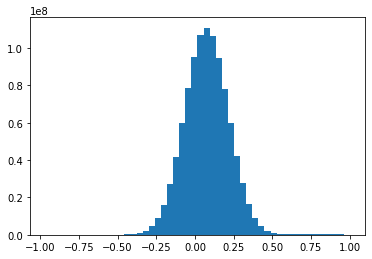

In [23]:
plt.hist(corr.flatten(),bins=50);

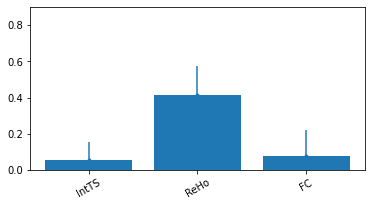

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*2,3))
plt.bar(range(3),mfcorr)
plt.errorbar(range(3),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(3),labels=feats,rotation=30)
plt.ylim([0,.9]);

# 4. Gradients of differential hippocampal FC

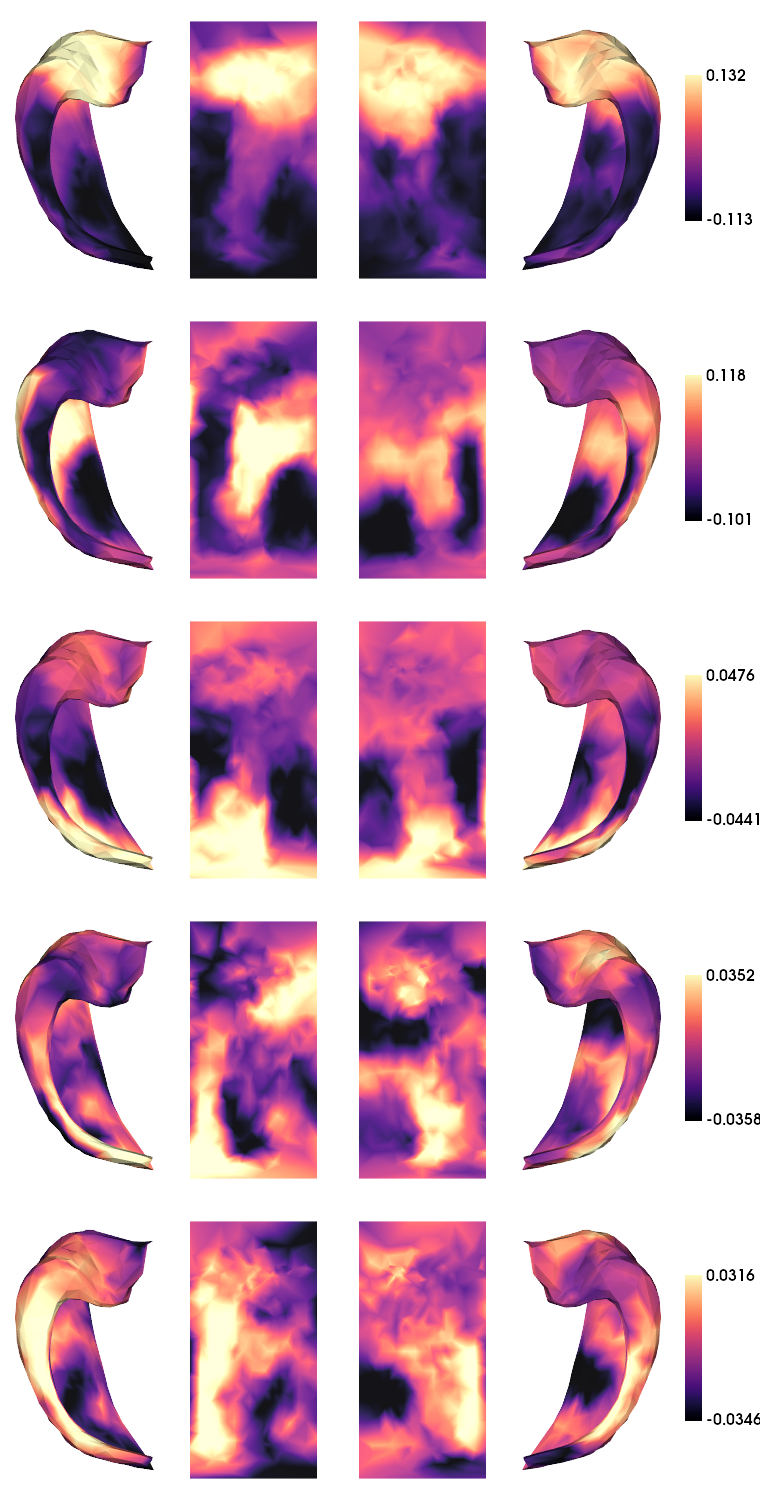

In [25]:
ngrads = 5
gradients = np.zeros((np.sum(shp),2,ngrads))
for h,hemi in enumerate(hemis):
    gm = GradientMaps(n_components=ngrads, kernel='normalized_angle', random_state=0, alignment='procrustes')
    gm.fit(np.nanmean(FC[:,:,h,:],axis=(2)))
    gradients[:,h,:] = gm.gradients_
    
# manually flip any L-R mismatch
gradients[:,1,:] = -gradients[:,1,:]
    
plotting.surfplot_canonical_foldunfold(gradients, den='2mm', hemis=hemis, labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='magma', share='row', color_bar='right', embed_nb=True)

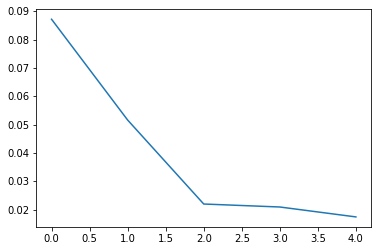

In [26]:
plt.plot(gm.lambdas_)

In [27]:
gm.lambdas_/np.sum(gm.lambdas_)

array([0.43756143, 0.25915543, 0.11046623, 0.10518694, 0.08762996])

In [ ]:
# save a copy of the 2D map
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):    
        cdat = gradients[ind[l],h,:]
        data_array = nib.gifti.GiftiDataArray(data=cdat)
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-FCG1to5_average-{len(subs)-len(missingsubs)}_hemi-{hemi}_den-2mm_label-{label}.shape.gii')

In [ ]:
# look only at FC to the rest of the neocortex for the top-bottom 10% of each gradient

nverts = np.sum(shp)
nvertsplit = int(nverts*.25)

diffval = np.ones([surf_lh.n_points + surf_rh.n_points,ngrads])*np.nan
botval = np.ones(surf_lh.n_points + surf_rh.n_points)*np.nan
topval = np.ones(surf_lh.n_points + surf_rh.n_points)*np.nan
for g in range(ngrads):
    for h,hemi in enumerate(hemis):
        bot = np.argpartition(gradients[:,h,g],nvertsplit)[:nvertsplit]
        top = np.argpartition(gradients[:,h,g],-nvertsplit)[-nvertsplit:]
        for i in range(200):
            botval[parc==(i+1+(h*200))] = np.nanmean(FC[bot,i,h,:],axis=(0,1))
            topval[parc==(i+1+(h*200))] = np.nanmean(FC[top,i,h,:],axis=(0,1))
        diffval[:,g] = topval-botval
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(diffval,ngrads), 
                 size=(800,200*ngrads), color_bar=True, cmap='magma', embed_nb=True,nan_color=(1, 1, 1, 1))

# 4. Gradients of differential hippocampal FC, averaging hemis

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)


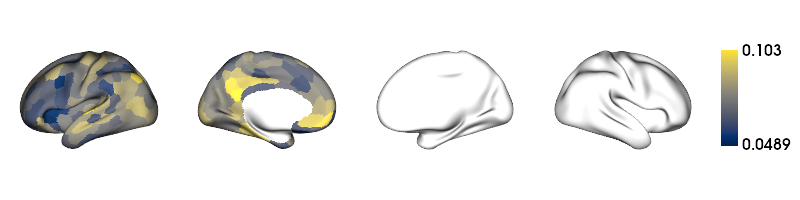

In [30]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points])*np.nan
for i in range(200):
    mc[parc==(i+1)] = np.nanmean(FC[:,i,:,:],axis=(0,1,2))
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,1), 
                 size=(800,200), color_bar=True, cmap='cividis', embed_nb=True,nan_color=(1, 1, 1, 1))

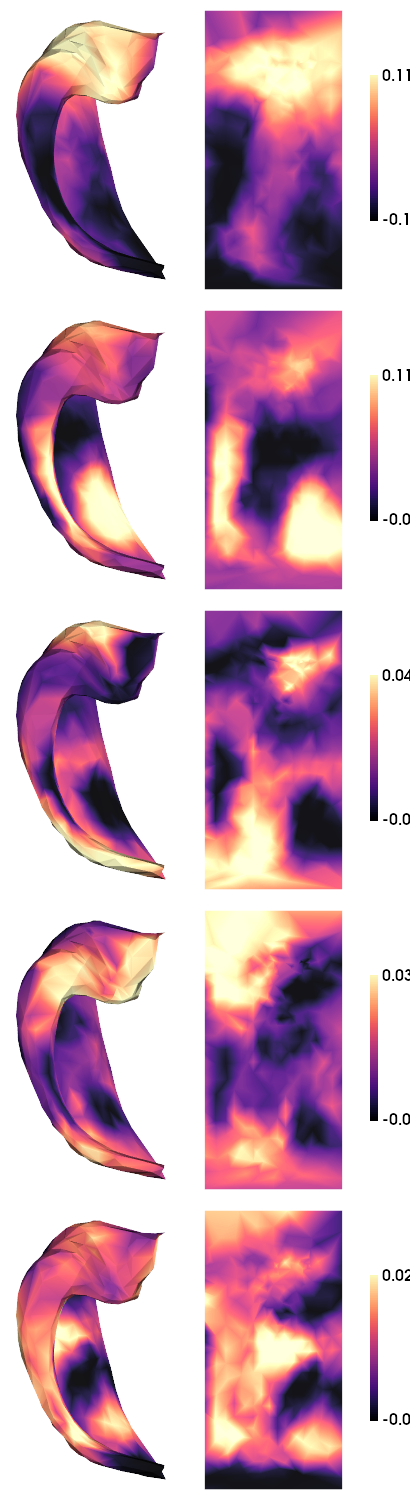

In [31]:
ngrads = 5
gm = GradientMaps(n_components=ngrads, kernel='normalized_angle', random_state=0, alignment='procrustes')
gm.fit(np.nanmean(FC,axis=(2,3)))
    
plotting.surfplot_canonical_foldunfold(gm.gradients_, den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='magma', share='row', color_bar='right', embed_nb=True)

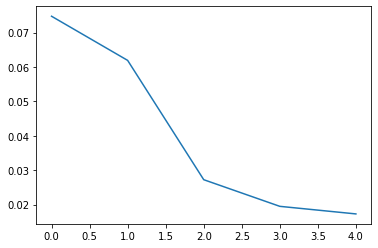

In [32]:
plt.plot(gm.lambdas_)

In [33]:
gm.lambdas_/np.sum(gm.lambdas_)

array([0.37241247, 0.30850062, 0.13574176, 0.09715842, 0.08618673])

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)
/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


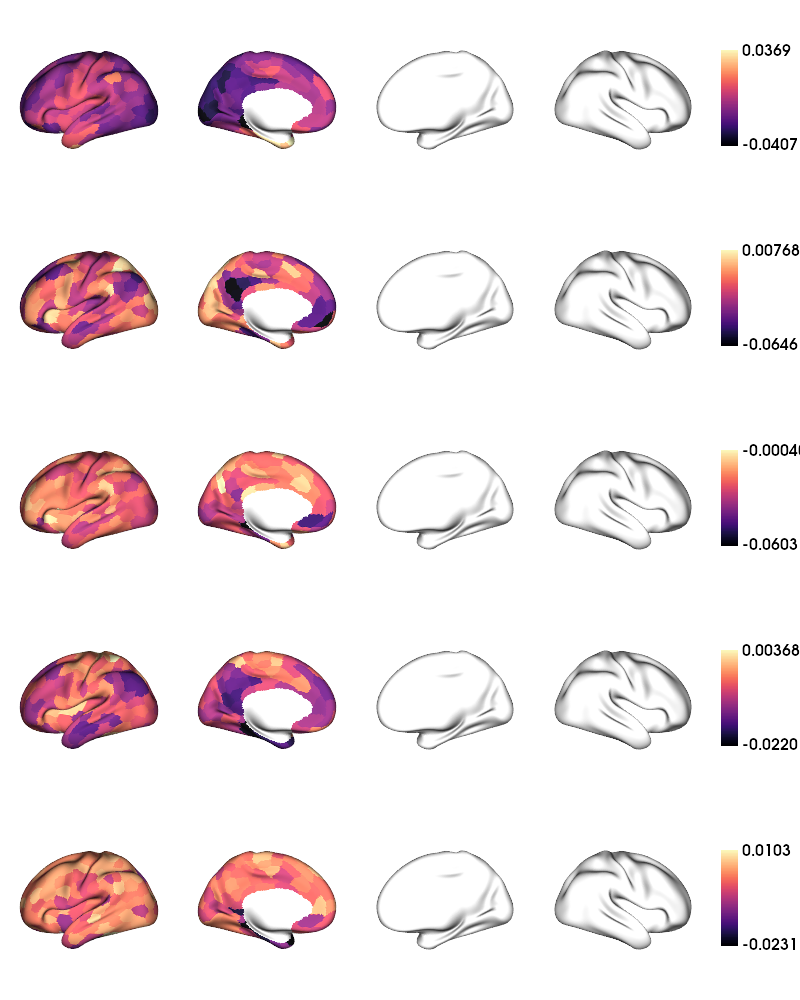

In [35]:
# look only at FC to the rest of the neocortex for the top-bottom 10% of each gradient

nverts = np.sum(shp)
nvertsplit = int(nverts*.25)

diffval = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points,ngrads])*np.nan
botval = np.ones(c69_inf_lh.n_points + c69_inf_rh.n_points)*np.nan
topval = np.ones(c69_inf_lh.n_points + c69_inf_rh.n_points)*np.nan
for g in range(ngrads):
    bot = np.argpartition(gm.gradients_[:,g],nvertsplit)[:nvertsplit]
    top = np.argpartition(gm.gradients_[:,g],-nvertsplit)[-nvertsplit:]
    for i in range(200):
        botval[parc==(i+1)] = np.nanmean(FC[bot,i,:,:],axis=(0,1,2))
        topval[parc==(i+1)] = np.nanmean(FC[top,i,:,:],axis=(0,1,2))
    diffval[:,g] = topval-botval
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(diffval,ngrads), 
                 size=(800,200*ngrads), color_bar=True, cmap='magma', embed_nb=True,nan_color=(1, 1, 1, 1))

# shelf

In [36]:
# save everything
import shelve
filename='../checkpoints/MRI-3T-rsfMRI.out'
my_shelf = shelve.open(filename,'n') # 'n' for new
for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except:
        # __builtins__, my_shelf, and imported modules can not be shelved.
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: art3d
ERROR shelving: c69_inf_lh
ERROR shelving: c69_inf_rh
ERROR shelving: corr
ERROR shelving: exit
ERROR shelving: fcorr
ERROR shelving: get_ipython
ERROR shelving: glob
ERROR shelving: my_shelf
ERROR shelving: nib
ERROR shelving: np
ERROR shelving: os
ERROR shelving: plotting
ERROR shelving: plt
ERROR shelving: quit
ERROR shelving: shelve
ERROR shelving: sys
ERROR shelving: utils


In [6]:
# load everything
import shelve
filename='../checkpoints/MRI-3T-rsfMRI.out'
my_shelf = shelve.open(filename)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

AttributeError: Can't get attribute 'plotwire' on <module '__main__'>